In [ ]:
%matplotlib inline

## Logistic Regression

In [ ]:
NAME = "Kenny Bun"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [ ]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2021-02-15 07:41:21--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  13.2MB/s    in 0.6s    

2021-02-15 07:41:22 (13.2 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [ ]:
import pandas as pd
import numpy as np
import glob


def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let us take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

# print(full_dat.shape, full_dat_out.shape)

### a) Understanding the Data 
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data? 

[Answer: the size of input shape is (4000, 25), and the number of parameter exist in the data is 25.]
*   Exaplain what the code provided above is trying to achieve.

[Answer: The code above is reading the raw data and put it in dataframe, then set all value equal to "-1" to "NaN". And the code also provided attribute to represent all features of the data with dictonary to store keys of attribute. "full_dat_out" is the full data which cotained all the features data for running logistic regression.]



### b) Run Logistic Regression


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [ ]:
### YOUR CODE HERE ###
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = full_dat_out[['HR', 'Gender', 'Age', 'Temp', 'Weight', 'Height', 'PaO2', 'PaCO2']].values, full_dat_out.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=144)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=144)

clf = LogisticRegression(random_state=144).fit(X_train, y_train)

### c) ROC curve

Write a function that, for a given threshold, calculates both the False Positive Rate (proportion of non-deaths identified as deaths) and True Positive Rate (proportion of deaths correctly identified as such) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


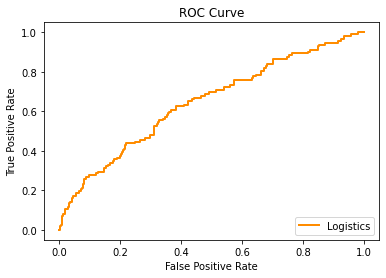

In [ ]:
### YOUR CODE HERE ###
from sklearn import metrics
import matplotlib.pyplot as plt

y_val_pred =  clf.predict_proba(X_val)

fpr_val, tpr_val, val_thresholds = metrics.roc_curve(y_val, y_val_pred[:, 1])

# Plot an ROC curve
plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=lw, label='Logistics' % val_thresholds[2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### d) Interpreting the ROC curve

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


[Based on the ROC curve, the approximation of the False Positive Rate says if the a patient is in ICU and flagged as high risk, they would be more likely to get treatment]


### e) Modelling Doctors' Decision-Making

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following Parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [ ]:
def prob_fail(t):
  fail = np.exp(-(t**2)/100)
  return fail

# If the doctor spent equal amount of time
t = 60/25
print(prob_fail(t))
dead_patient = prob_fail(t) * 10
print(dead_patient)

print(np.sum(y_val==1)*prob_fail(t))

y_thres = (clf.predict_proba(X_val)[:, 1] > 0.20).astype(int)
check_patient = len(np.where(y_thres==1)[0])
print(check_patient)
risk_patient = len(np.where(y_thres==0)[0])
print(risk_patient)
t3 = (len(y_val)/25 * 60)/check_patient
p_fail3 = np.exp(-(t3**2)/100)
print(p_fail3)
print(risk_patient*p_fail3)

0.9440274829178357
9.440274829178357
105.7310780867976
148
652
0.1858193567283408
121.1542205868782


1. If the doctor reviews all the files, spends an equal amount of time on each part, there are 9.44 patients to die if the doctor intervenes when they see that that's needed. And the percentage of patient who are expected to die, out of 25, is 9.4/25 * 100 = 37.6%. 

2. There would be 105.73 patients expected to die if the doctor intervenes correctly when they know they should do that for all patient charts in the validation set.

3. Assuming we only check patients who above threshold, then there are 121.15 expected to die.

### f) Modelling Doctors' Decision-Making - Revisited


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




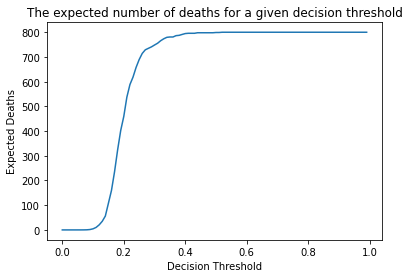

In [ ]:
### YOUR CODE HERE ###
thresh = np.arange(0, 1, 0.01)

def compute_expected_deaths(t):
  y_pred_f = (clf.predict_proba(X_val)[:, 1] > t).astype(int)
  checked_patient = len(np.where(y_pred_f == 1)[0])
  ignored_patient = len(np.where(y_pred_f == 0)[0])

  t = checked_patient/25
  p_fail = np.exp(-(t**2)/100)
  return ignored_patient*p_fail

expected_deaths = []
for t in thresh:
  expected_deaths.append(compute_expected_deaths(t))

plt.plot(thresh, expected_deaths)

plt.xlabel('Decision Threshold')
plt.ylabel('Expected Deaths')

plt.title('The expected number of deaths for a given decision threshold')
plt.show()

[The minimum threshold is around 0.05]

### g) Modelling Doctors' Decision-Making - Testing

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [ ]:
### YOUR CODE HERE ###
def compute_expected_deaths(t):
  y_preds_f = (clf.predict_proba(X_test)[:, 1] > t).astype(int)
  patients_reviewed = len(np.where(y_preds_f == 1)[0])
  patients_ignored = len(np.where(y_preds_f == 0)[0])
  t_f = patients_reviewed / 25
  p_fail = np.exp(-(t_f**2) / 100)
  return patients_ignored * p_fail

compute_expected_deaths(0.05)
deaths_in_test = len(np.where(y_test == 1)[0])
print(deaths_in_test)

115


[115 lives would be saved]

## Question 2 - Neural Networks
---

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#### Load the Fashion-MNIST dataset
Keras has lots of datsets that you can just load right into python numpy arrays, see: https://keras.io/datasets/

We will be using the Fashion-MNIST dataset, which is a cool little dataset with gray scale $28\times28$ images of articles of clothing.
Keep in mind that they will be downloaded from the internet, so it may take a while.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
# Splitting training and test data and corresponding labels 
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

In [ ]:
def show_image(index):
    plt.figure()
    # cmap=plt.cm.binary allows us show the picture in grayscale
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[index]])
    plt.colorbar() # Adds a bar to the side with values
    plt.show()

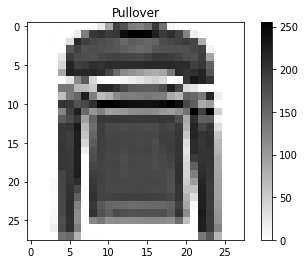

In [ ]:
# You can visualize images from different clothing type classes.
# Try passing different indices
show_image(5)

### a) Data Preprocessing
As you can see above, the images are valued from $[0,255]$. This is the normal range for images. Recall from the previous lectures and class excercises that we need to normalize our data.

In order to normalize our data to $[0,1]$ we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to $[0,1]$ the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different.




Normalize BOTH the training and testing images using the above equation.

In [ ]:
train_images = train_images/255
test_images = test_images/255

If we show the image again, you will see the values are all scaled correctly.

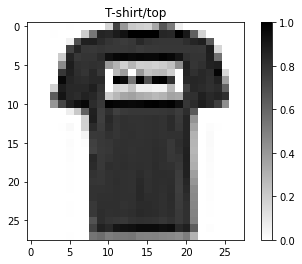

In [ ]:
show_image(1)

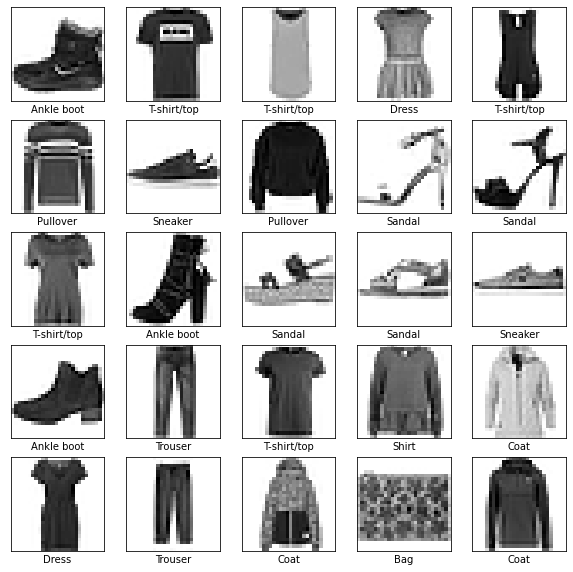

In [ ]:
# Let's sample our data to see what kind of images are stored.
# See documentation for subplot here:
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplot.html
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### b) Data visualization
Since our data is composed of grayscale images (one channel) with a resolution of $28\times28$, we can think of this as the images existing in a $28\times28=784$ dimensional space. This means that every single image in our dataset can be represented by a vector of length $784$.

Please reshape BOTH the training and testing images to be $784D$. 

*Hint: look into numpy.reshape().*


In [ ]:
print(f'Before reshape, train_images shape: {train_images.shape} test_images shape: {test_images.shape}')
train_images = train_images.reshape(60000, -1)
test_images = test_images.reshape(10000, -1)
print(f'Before reshape, train_images shape: {train_images.shape} test_images shape: {test_images.shape}')

Before reshape, train_images shape: (60000, 28, 28) test_images shape: (10000, 28, 28)
Before reshape, train_images shape: (60000, 784) test_images shape: (10000, 784)


We create a dataframe using our training and testing data to keep everything tidy.

In [ ]:
# Add training data into a dataframe
img_data = {f"z{i}":train_images[:,i] for i in range(784)}
img_data["label"] = train_labels
df_img_train = pd.DataFrame(img_data)
df_img_train["class"] = df_img_train["label"].map(class_dict)
df_img_train.head()

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,...,z746,z747,z748,z749,z750,z751,z752,z753,z754,z755,z756,z757,z758,z759,z760,z761,z762,z763,z764,z765,z766,z767,z768,z769,z770,z771,z772,z773,z774,z775,z776,z777,z778,z779,z780,z781,z782,z783,label,class
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9,Ankle boot
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,0.160784,0.737255,0.403922,0.211765,0.188235,0.168627,0.341176,0.658824,0.521569,0.062745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.192157,0.533333,0.858824,0.847059,0.894118,...,0.952941,0.839216,0.878431,0.635294,0.000000,0.007843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.000000,0.0,0.545098,0.572549,0.509804,0.529412,0.529412,0.537255,0.490196,0.486275,0.490196,0.474510,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0,T-shirt/top
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,0.462745,0.094118,0.000000,0.000000,0.000000,0.000000,0.000000,0.188235,0.345098,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.047059,0.392157,0.831373,0.803922,...,0.294118,0.039216,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.000000,0.000000,0.070588,0.164706,0.223529,0.219608,0.125490,0.031373,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,T-shirt/top
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,0.686275,0.611765,0.250980,0.054902,0.211765,0.537255,0.800000,0.760784,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.286275,0.729412,0.694118,0.717647,0.686275,0.737255,...,0.333333,0.627451,0.521569,0.392157,0.047059,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015686,0.0,0.007843,0.000000,0.137255,0.015686,0.129412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3,Dress
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.741176,0.807843,0.733333,0.125490,...,1.000000,0.274510,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.239216,0.400000,0.658824,0.098039,0.000000,0.545098,0.631373,0.290196,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,T-shirt/top


In [ ]:
# Add test data into a dataframe
img_data = {f"z{i}":test_images[:,i] for i in range(784)}
img_data["label"] = test_labels
df_img_test = pd.DataFrame(img_data)
df_img_test["class"] = df_img_test["label"].map(class_dict)
df_img_test.head()

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,...,z746,z747,z748,z749,z750,z751,z752,z753,z754,z755,z756,z757,z758,z759,z760,z761,z762,z763,z764,z765,z766,z767,z768,z769,z770,z771,z772,z773,z774,z775,z776,z777,z778,z779,z780,z781,z782,z783,label,class
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,9,Ankle boot
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.050980,0.262745,0.000000,0.000000,0.000000,0.000000,0.196078,0.149020,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.031373,0.470588,0.819608,0.886275,0.968627,...,0.000000,0.000000,0.000000,0.152941,0.976471,1.0,0.482353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192157,0.803922,0.772549,0.043137,0.0,0.015686,0.003922,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0,2,Pullover
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.262745,0.694118,0.505882,0.600000,0.458824,0.505882,0.572549,0.552941,0.686275,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.007843,0.000000,0.768627,1.000000,...,0.988235,0.466667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.384314,0.623529,0.278431,0.000000,0.000000,0.266667,0.690196,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,Trouser
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,0.482353,0.423529,0.388235,0.388235,0.329412,0.325490,0.337255,0.360784,0.274510,0.023529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.415686,0.972549,0.901961,...,0.180392,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.078431,0.682353,0.396078,0.000000,0.000000,0.000000,0.572549,0.572549,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1,Trouser
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,0.000000,0.223529,0.262745,0.286275,0.298039,0.298039,0.325490,0.243137,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.003922,0.003922,0.0,0.000000,0.050980,0.309804,0.501961,0.788235,...,0.772549,0.713725,0.635294,0.239216,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.117647,0.282353,0.372549,0.427451,0.435294,0.435294,0.415686,0.396078,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,6,Shirt


Now we have our data reshaped into the $784D$ vectors, using these we can try and visualize the space they live in. However, accurately visualizing high dimensional spaces like these would be practically impossible. We use tools like principle component analysis (PCA), and tSNE to create a projection of this $784D$ space into a more digestible $2D$ or even $3D$.

Don't worry about how they work just yet, we are just using them to visualize our data. Just run the cells to see some cool visuals.

You can direcly use the built in PCA and TSNE models from sklearn, you import them like so:



In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

These tools require our data to be scaled correctly.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
standardized_data = StandardScaler().fit_transform(train_images)

In [ ]:
n_comps = 50
pca = PCA(n_components=n_comps)
pca_features = pca.fit_transform(standardized_data)

In [ ]:
# Add data into a dataframe
pca_data = {f"z{i}":pca_features[:,i] for i in range(n_comps)}
pca_data["label"] = train_labels
df_pca = pd.DataFrame(pca_data)
df_pca["class"] = df_pca["label"].map(class_dict)
df_pca.head()

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32,z33,z34,z35,z36,z37,z38,z39,z40,z41,z42,z43,z44,z45,z46,z47,z48,z49,label,class
0,-0.801175,20.866749,-12.945136,3.311432,-6.638684,1.052827,-0.103101,-5.388831,-3.998838,2.178397,0.635340,2.156509,-2.014092,2.092057,1.566664,0.128717,0.506611,1.235007,1.707906,1.372470,-0.636183,-0.738660,1.142368,0.408791,-2.749941,-2.044292,0.794461,-0.231450,2.231264,-3.830494,0.877494,2.431079,3.091486,-0.102899,-0.143318,-0.717635,-2.148888,-0.629614,1.353721,0.017574,1.664735,-0.446970,0.937355,2.231120,2.126619,-2.478336,0.206986,-0.481816,0.700084,0.366412,9,Ankle boot
1,17.074206,-4.968512,-2.077820,5.895035,11.006847,4.803589,-11.846814,1.595990,-2.131134,-2.342785,0.710332,0.547549,0.945599,-2.220134,-2.886607,2.248241,1.077930,-1.710419,-0.250427,-2.760250,-0.043261,3.228127,3.400317,0.135896,1.626510,1.887171,-0.657260,1.007620,-1.740441,-2.341322,0.603709,0.259655,-1.003864,-2.317321,-1.869267,-0.031646,-4.213305,0.683997,1.407057,1.849141,0.628049,1.986966,0.071221,-3.208068,-1.243788,0.212729,2.420179,1.898334,-0.222343,0.246843,0,T-shirt/top
2,-9.601641,-12.296101,1.082284,2.580125,0.233065,-0.981053,1.219416,-1.124080,-0.818486,-0.131103,-0.099562,0.542964,0.531622,1.435667,-0.231833,-1.719156,-1.293825,-0.955768,-0.409480,-0.141628,0.197178,0.088120,0.982531,-0.528418,-0.322538,-1.773911,-0.623300,-1.379792,0.831051,0.016556,0.676698,0.351082,0.008481,-0.044934,0.265856,0.471897,-0.600337,-0.207160,-0.231531,0.064425,2.100052,0.107364,-1.393754,0.988340,-0.871770,0.692439,0.987417,0.892221,-1.892197,0.827236,0,T-shirt/top
3,-0.311206,-11.576765,3.223877,4.267873,2.366103,0.578038,-2.116618,-0.658573,-0.804144,2.684316,-2.654618,2.896903,-2.221666,3.471284,-3.451950,-2.855034,0.185207,-1.045451,0.066168,0.961088,2.024759,0.981617,2.042136,-0.449535,-0.857354,-1.541564,-1.308204,-2.257381,2.886292,-0.397265,0.350352,0.718750,0.283449,0.093382,0.568935,1.480393,-0.007981,-0.544856,-0.764953,-0.204174,-0.552250,0.821565,-1.087821,0.842741,-1.486368,1.344137,-0.712586,-0.291421,1.293339,0.970962,3,Dress
4,8.963833,-12.867738,-10.208862,-2.650564,-0.611276,3.657580,3.113013,0.510477,-1.683233,-0.392198,2.691413,2.082369,-1.374487,2.546079,-0.757512,-4.770236,-0.079164,0.953676,-2.602584,-2.326581,1.542452,-0.697811,-1.395016,-0.157132,-1.520474,-2.142053,-1.389164,0.572834,2.530911,-0.389084,0.695564,-0.313769,-0.789149,1.760366,-1.175211,1.833741,0.021622,0.189750,-0.212961,-2.435659,1.202136,-0.419746,-0.512425,0.519421,0.271386,-0.084887,0.683751,0.363848,-0.759711,-0.760405,0,T-shirt/top


In [ ]:
print(f'Compressed dimension of {train_images.shape[1]} to {n_comps} maintaining {pca.explained_variance_ratio_.sum()*100:.2f}% of information.')

Compressed dimension of 784 to 50 maintaining 80.06% of information.


In [ ]:
model = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)

In [ ]:
print('This may take a few minutes...')
# We are only using the first 10000 data points, this is sufficient for this application.
visualization_data = model.fit_transform(pca_features[:10000])
print('Done.')

This may take a few minutes...
Done.


In [ ]:
data_to_visualize = {"z1":visualization_data[:,0], "z2":visualization_data[:,1], "label":train_labels[:10000]}
df_visualize = pd.DataFrame(data_to_visualize)
df_visualize["class"] = df_visualize["label"].map(class_dict)
df_visualize.head()

,z1,z2,label,class
0,-12.647074,66.090523,9,Ankle boot
1,-35.301125,-50.450298,0,T-shirt/top
2,-23.181784,0.367965,0,T-shirt/top
3,-24.897066,-21.863243,3,Dress
4,-55.136627,-7.398406,0,T-shirt/top


#### Projecting the classes in 2D for visualization
These images, which started out as $784$ dimensional vectors, are now being projected into a $2D$ space. Don't worry about how tSNE works, it essentially tries to estimate and project distances in a high dimensional space to $2D$. Below we can see a pretty good representation of the space where our data lives.

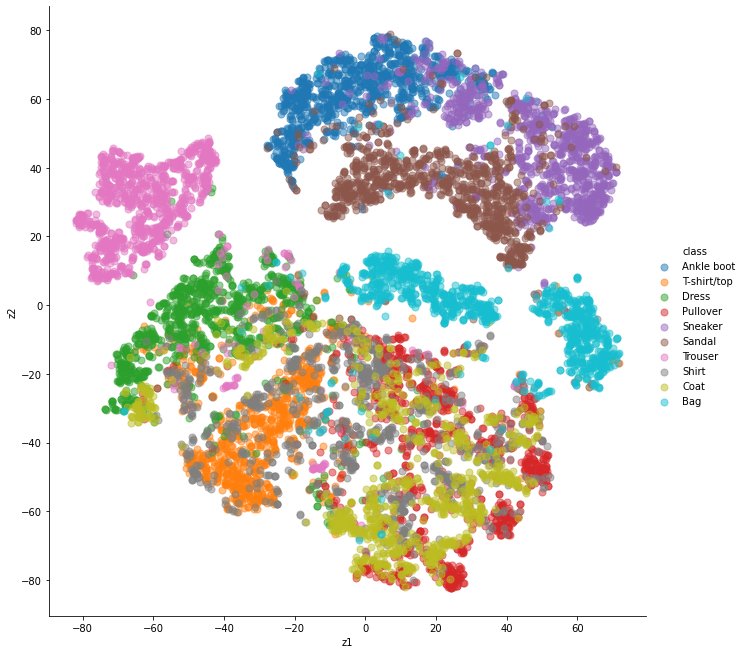

In [ ]:
sns.lmplot(x='z1',
           y='z2',
           data=df_visualize, 
           fit_reg=False, 
           hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.5})

### c) Linearly Separable
*Some* of the data is easily to separate with a line, this concept is called linear separability. Below we plot only the Ankle Boot and Trouser class. How do you think a logistic regression model will fare at distinguishing Ankle boots from Trousers? Please explain.


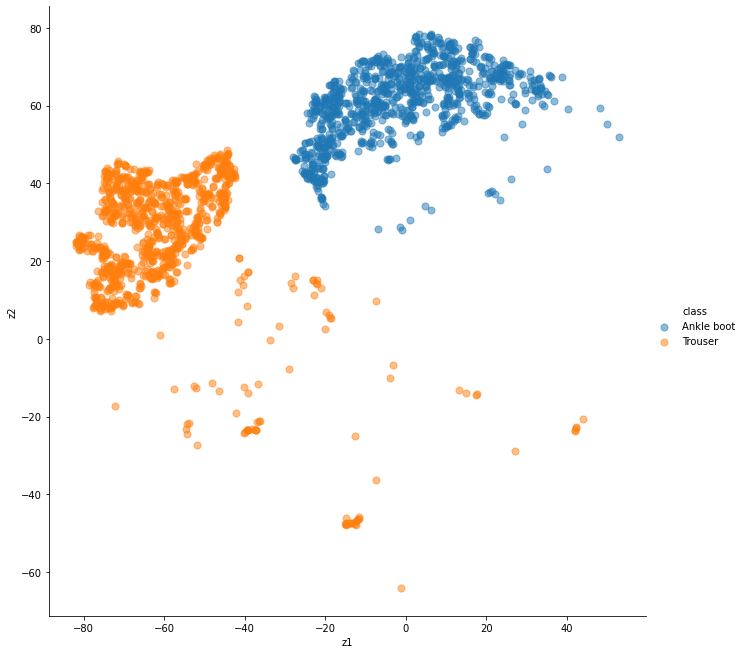

In [ ]:
sns.lmplot(x='z1',
           y='z2',
           data=df_visualize[(df_visualize["class"] == "Ankle boot") | (df_visualize["class"] == "Trouser")], 
           fit_reg=False, 
           hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.5})

[Logistic Regression can separate the data very well. Since the data is linearly separable, there are many perfect option to fit a line between Ankle Boot and Trouser. In addition, observing the data cluster in graph, logistic regression is sufficient to fit the model perfectly.]

### d) Not Linearly Separable
Now lets plot something harder to classify, the Pullover and Coat classes which are basically mixed together. How do you think a logistic regression model will fare at distinguishing Pullovers from Coats? Please explain.

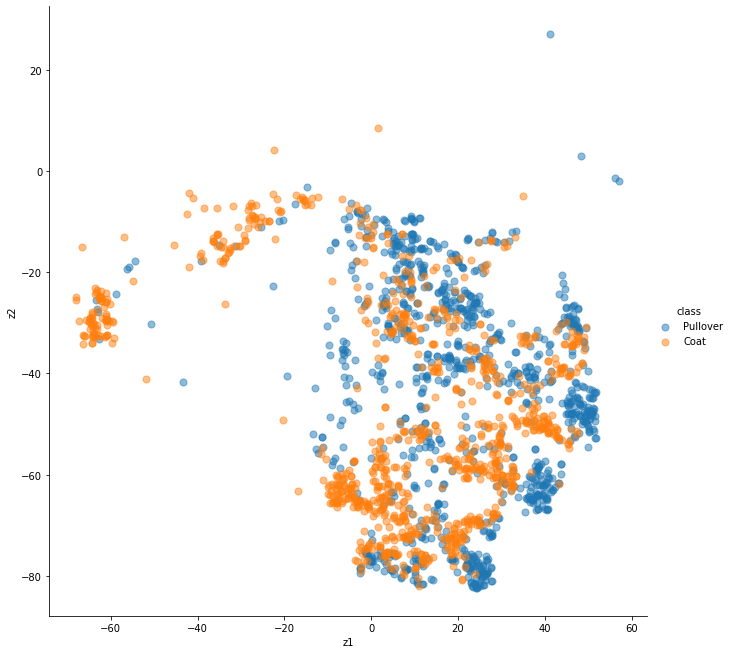

In [ ]:
sns.lmplot(x='z1',
           y='z2',
           data=df_visualize[(df_visualize["class"] == "Pullover") | (df_visualize["class"] == "Coat")], 
           fit_reg=False, 
           hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.5})

[As two classes are mixed, it is really difficult to impossible for logistic regression to distinguish the Pullover and Coat.]

### e) A Neural Network Classifier


In this question we will build a neural network with Keras that can beat our logistic regression model at classifying Pullovers vs. Coats.

In [ ]:
from tensorflow.keras.layers import Input, Dense # Only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

# Define an input layer with the correct shape for your data
input_layer = Input(shape=(784,))

# Pass the input layer's output to a dense of size 100, choose whatever activation you think is suitable
x = Dense(100, activation="tanh")(input_layer)

# Pass the previouses hidden layer's output to a dense of size 1 for classification, what activation do we need to use?
output = Dense(1, activation="sigmoid")(x)

# Define a model with it's input as your input layer and output as your output layer
model = Model(input_layer, output)

In [ ]:
# Show a summary of your model
### YOUR CODE HERE ###
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile your model with your chosen optimizer, binary cross entropy for the loss, and accuracy as the metric

### YOUR CODE HERE ###
# sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

In [ ]:
def get_data_subset(df, classes=[], shuffle=True, shuffle_seed=42):
  if classes == []:
    return None
  else:
    df_filter = df[(df["class"] == classes[0]) | (df["class"] == classes[1])].copy()
    df_filter["binary_label"] = 0
    df_filter.loc[df["class"] == classes[1], "binary_label"] = 1
    data = df_filter.filter(regex=("z[0-9]+")).values
    labels = df_filter["binary_label"].values
    if shuffle:
      np.random.seed(shuffle_seed)
      np.random.shuffle(data)
      np.random.seed(shuffle_seed)
      np.random.shuffle(labels)
  
  return data, labels.reshape(-1,1)

X, y = get_data_subset(df_img_train, classes=["Pullover", "Coat"])

# Call fit on your model passing in the X, y data above with validation split of 0.2 and train for 100 epochs
hist = model.fit(X, y, epochs=100, validation_split=0.2, shuffle=True)

Epoch 1/100
300/300 [==============================] - 2s 5ms/step - loss: 0.4688 - accuracy: 0.7740 - val_loss: 0.3389 - val_accuracy: 0.8625
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3541 - accuracy: 0.8483 - val_loss: 0.3547 - val_accuracy: 0.8562
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3109 - accuracy: 0.8675 - val_loss: 0.2964 - val_accuracy: 0.8846
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.2934 - accuracy: 0.8790 - val_loss: 0.2911 - val_accuracy: 0.8863
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.2773 - accuracy: 0.8844 - val_loss: 0.2962 - val_accuracy: 0.8800
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.2584 - accuracy: 0.8947 - val_loss: 0.2801 - val_accuracy: 0.8867
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.2590 - accuracy: 0.8908 - val_loss: 0.3238 - val_accuracy: 0.8567

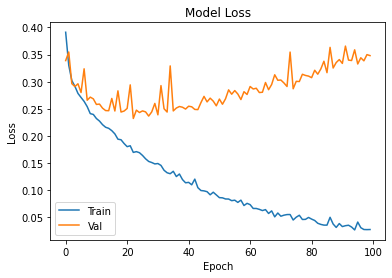

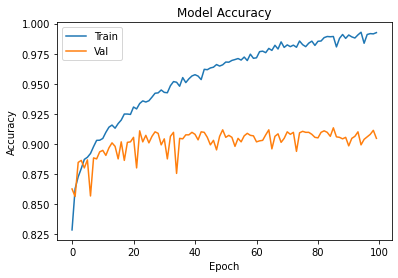

In [ ]:
# Implement plot_losses and plot_accuracies functions that receives training 'history'
# as their input and plot loss function and accuracy functions on the training set and 
# validation set

def plot_losses(hist):
    ### YOUR CODE HERE ###
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

def plot_accuracies(hist):
    ### YOUR CODE HERE ###
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

### f) Observation
1. How did your neural network perform? 
2. What hyperparameters and optimizer did you choose to increase performance and accuracy of the model? 
3. Why do you think your neural network can beat a logistic regression model?


1. I selected Adam optimizer for neural network perform my model, the model accuracy is reaching 99% with small percentage loss. However, the model fit is unstable because the model perform in subset data input.
2. I used SGD and Adam. And I chose Keras Adam optimizer since it performed a bit better in term accuracy and loss.
3. This neural network can beat a logistic regression model because this neural network has more complex solution to perform the model more accurately. With the help of activation function and optimizer, the model has better classifer than a logistic regression model. Logistic regression model fails whenever data are complex. 